Get data and dataset summary

In [1]:
import pandas as pd
import re
from textblob import TextBlob
import matplotlib.pyplot as plt

In [2]:
# Read csv
trump_posts = pd.read_csv('trump_90_days_all_updated.csv')

# Display shape and columns of the dataframe
print(trump_posts.shape)
print(trump_posts.columns)
print(trump_posts.head())

(9368, 23)
Index(['PostId', 'PostUrl', 'PostEngagement', 'Platform', 'ChannelID',
       'ChannelName', 'ChannelUid', 'ChannelUrl', 'ChannelEngagement',
       'post_body_text', 'GoogleAudioText', 'VoskAudioText',
       'EmbeddedContentText', 'published_at', 'post_data', 'post_media_urls',
       'LikesCount', 'SharesCount', 'CommentsCount', 'ViewsCount',
       'post_media_file', 'embedded_post_text', 'search_data'],
      dtype='object')
      PostId                                            PostUrl  \
0  386406074  https://twitter.com/TrumpWarRoom/status/186394...   
1  386259208  https://twitter.com/TrumpWarRoom/status/186378...   
2  386212548  https://truthsocial.com/@realDonaldTrump/11358...   
3  386313512           https://www.instagram.com/p/DDGbmhtMyr_/   
4  386212560  https://truthsocial.com/@realDonaldTrump/11358...   

   PostEngagement         Platform  ChannelID                ChannelName  \
0             NaN          Twitter    8423211             Trump War Room   


In [3]:
# Count the number of posts on each platform
platform_counts = trump_posts['Platform'].value_counts()
print(platform_counts)

Twitter            6254
TruthSocial        2277
FacebookDirect      452
InstagramDirect     341
TikTok               44
Name: Platform, dtype: int64


Define racist sentiment severity scale

In [4]:
# Clean the text in the `post_body_text` column
def clean_text(text):
    if pd.isna(text):
        return ""
    # Remove HTML tags, links, and special characters
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'http\S+|www.\S+', '', text)  # Remove links
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    return text.strip()

trump_posts['cleaned_text'] = trump_posts['post_body_text'].apply(clean_text)

# Define function for evaluation of racist sentiment severity
def evaluate_racism_level(post_text):
    if not post_text.strip():  # Handle empty or blank posts
        return 0  # No racism detected

    # Analyze sentiment polarity (-1 to 1 scale)
    sentiment = TextBlob(post_text).sentiment.polarity

    # Normalize the text to lowercase for easier keyword matching
    lower_text = post_text.lower()

    # Keywords/phrases indicating overt racism (Level 4)
    overt_racism_keywords = ["illegal alien monster", "this animal", "subhuman", "racial inferiority"]

    # Keywords/phrases indicating explicit racially charged language (Level 3)
    explicit_keywords = ["invaders", "take over", "white genocide", "racial hatred"]

    # Keywords/phrases indicating implicit racial charge or divisiveness (Level 2)
    implicit_keywords = ["critical race theory", "race baiting", "racial agenda"]

    # Check for overt racism
    if any(phrase in lower_text for phrase in overt_racism_keywords):
        return 4

    # Check for explicit racially charged language
    if any(phrase in lower_text for phrase in explicit_keywords):
        return 3

    # Check for implicit racial charge or divisiveness
    if any(phrase in lower_text for phrase in implicit_keywords):
        return 2

    # Check for insensitivity or polarizing context with negative sentiment (Level 1)
    if "race" in lower_text or "ethnic" in lower_text:
        return 1 if sentiment >= 0 else 2

    # Default to no racism detected (Level 0)
    return 0


Apply evaluation function to dataset

In [5]:
# Apply the evaluation function to the dataset
trump_posts['racism_level'] = trump_posts['cleaned_text'].apply(evaluate_racism_level)

# Filter out rows where the cleaned text is empty
filtered_data = trump_posts[trump_posts['cleaned_text'].str.strip() != ""]

# Create a frequency table for racism levels by platform
frequency_table = filtered_data.groupby(['Platform', 'racism_level']).size().unstack(fill_value=0)

# Calculate percentages for each platform
platform_totals = frequency_table.sum(axis=1)
percentage_table = (frequency_table.T / platform_totals).T * 100

print(frequency_table)
print(percentage_table)

racism_level        0   1   2  3  4
Platform                           
FacebookDirect    292   3   0  0  0
InstagramDirect   214   3   0  0  0
TikTok             41   0   0  0  0
TruthSocial      1559  24   8  2  1
Twitter          5951  57  32  3  6
racism_level              0         1         2         3         4
Platform                                                           
FacebookDirect    98.983051  1.016949  0.000000  0.000000  0.000000
InstagramDirect   98.617512  1.382488  0.000000  0.000000  0.000000
TikTok           100.000000  0.000000  0.000000  0.000000  0.000000
TruthSocial       97.804266  1.505646  0.501882  0.125471  0.062735
Twitter           98.379898  0.942305  0.529013  0.049595  0.099190


Create bar graph for the proportion of platforms by racism level

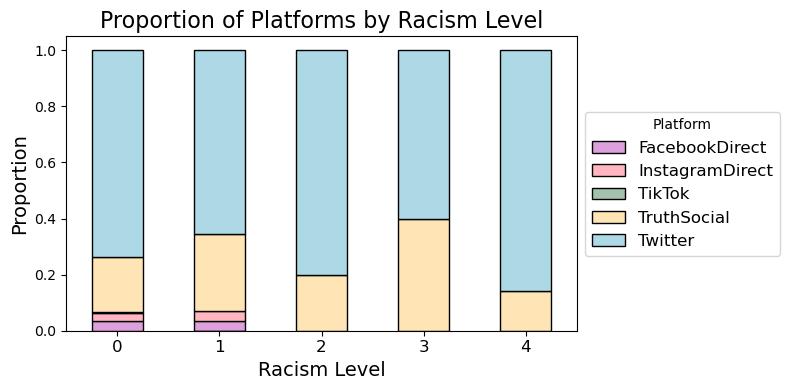

In [6]:
# Normalize the frequency table to make total bar height the same for each racism level
normalized_by_level = frequency_table.div(frequency_table.sum(axis=0), axis=1)

# Define color palette
color_palette = ['#DDA0DD', '#FFB6C1', '#A3C1AD', '#FFE4B5', '#ADD8E6']  # TikTok, TruthSocial, Facebook, Instagram, Twitter

# Create a stacked bar graph for sentiment levels
fig, ax = plt.subplots(figsize=(8, 4))
normalized_by_level.T.plot(kind='bar', stacked=True, ax=ax, edgecolor='black', color=color_palette)

# Add titles and labels
ax.set_title('Proportion of Platforms by Racism Level', fontsize=16)
ax.set_xlabel('Racism Level', fontsize=14)
ax.set_ylabel('Proportion', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=12)

# Move the legend to the side
ax.legend(title='Platform', fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.tight_layout()
plt.show()


Create time series graph for Twitter

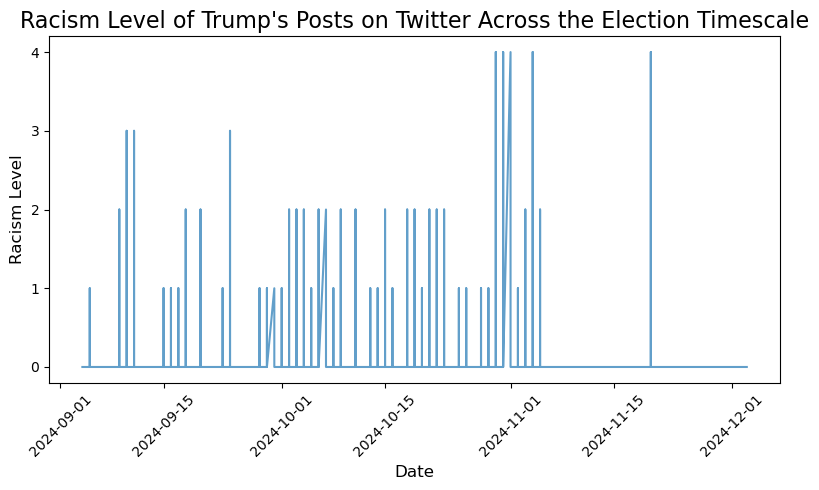

In [7]:
twitter_posts=trump_posts[['published_at','racism_level']][trump_posts['Platform']=='Twitter']

if 'published_at' in twitter_posts.columns:
    twitter_posts['published_at'] = twitter_posts['published_at'].astype(str)
    twitter_date = pd.to_datetime(twitter_posts['published_at'].map(lambda d: d.split('T')[0]))

    # Create a line plot
    plt.figure(figsize=(8, 5))
    plt.plot(twitter_date, twitter_posts['racism_level'], linestyle='-', alpha=0.7)

    # Set title and axis labels
    plt.title("Racism Level of Trump's Posts on Twitter Across the Election Timescale", fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Racism Level', fontsize=12)

    # Whole numbers on the y-axis
    plt.yticks(range(twitter_posts['racism_level'].min(), twitter_posts['racism_level'].max() + 1))

    # Rotate x-axis labels
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.show()


Create time series graph for Truth Social

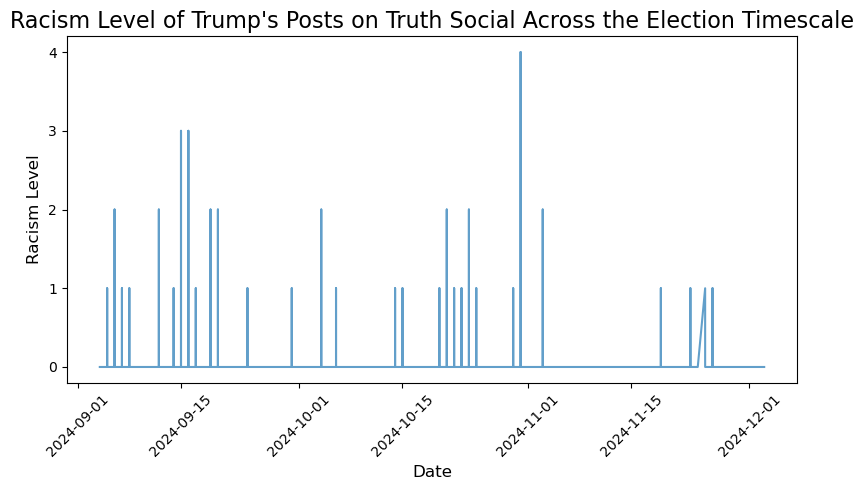

In [8]:
truthsocial_posts=trump_posts[['published_at','racism_level']][trump_posts['Platform']=='TruthSocial']

if 'published_at' in truthsocial_posts.columns:
    truthsocial_posts['published_at'] = truthsocial_posts['published_at'].astype(str)
    truthsocial_date = pd.to_datetime(truthsocial_posts['published_at'].map(lambda d: d.split('T')[0]))

    # Create a line plot
    plt.figure(figsize=(8, 5))
    plt.plot(truthsocial_date, truthsocial_posts['racism_level'], linestyle='-', alpha=0.7)

    # Set title and axis labels
    plt.title("Racism Level of Trump's Posts on Truth Social Across the Election Timescale", fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Racism Level', fontsize=12)

    # Whole numbers on the y-axis
    plt.yticks(range(truthsocial_posts['racism_level'].min(), truthsocial_posts['racism_level'].max() + 1))

    # Rotate x-axis labels
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.show()

Create chart for racist sentiment severity scale

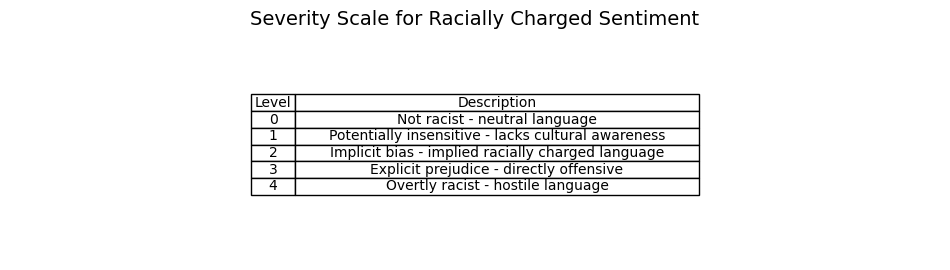

In [9]:
# Data for the chart
racism_scale_chart = {
    "Level": [0, 1, 2, 3, 4],
    "Description": [
        "Not racist - neutral language",
        "Potentially insensitive - lacks cultural awareness",
        "Implicit bias - implied racially charged language",
        "Explicit prejudice - directly offensive",
        "Overtly racist - hostile language"
    ]
}

# Create a dataframe
df = pd.DataFrame(racism_scale_chart)

# Plot the data as a table
fig, ax = plt.subplots(figsize=(12, 3))
ax.axis('tight')
ax.axis('off')

# Create a table
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

# Adjust font size and column width
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(df.columns))))

# Adjust cell margins (increase space around text)
for key, cell in table.get_celld().items():
    cell.set_text_props(ha='center', va='center', wrap=True)  # Center text and allow wrapping


# Add a title
plt.title("Severity Scale for Racially Charged Sentiment", fontsize=14, pad=1)

# Show the table
plt.show()